In [1]:
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error,mean_absolute_error, mean_absolute_percentage_error
import numpy as np
import itertools
from prophet.plot import plot_cross_validation_metric
from prophet.diagnostics import performance_metrics
from prophet.diagnostics import cross_validation

In [2]:
df=pd.read_csv('product h.csv', parse_dates=['Month-Year'])


In [3]:
sales_h= df.drop(['Product Name','Product Category','Month','Year','Month No.'],axis=1)

In [4]:
sales_h = sales_h.rename(columns={'Month-Year': 'ds',
                        'Sales': 'y'})

sales_h.head(5)

,ds,y,Market Size,Marketing Expense
0,2019-01-01,62686,142038,447509
1,2019-02-01,74426,168635,531319
2,2019-03-01,91347,206976,652116
3,2019-04-01,60600,137309,432617
4,2019-05-01,37374,84683,266809


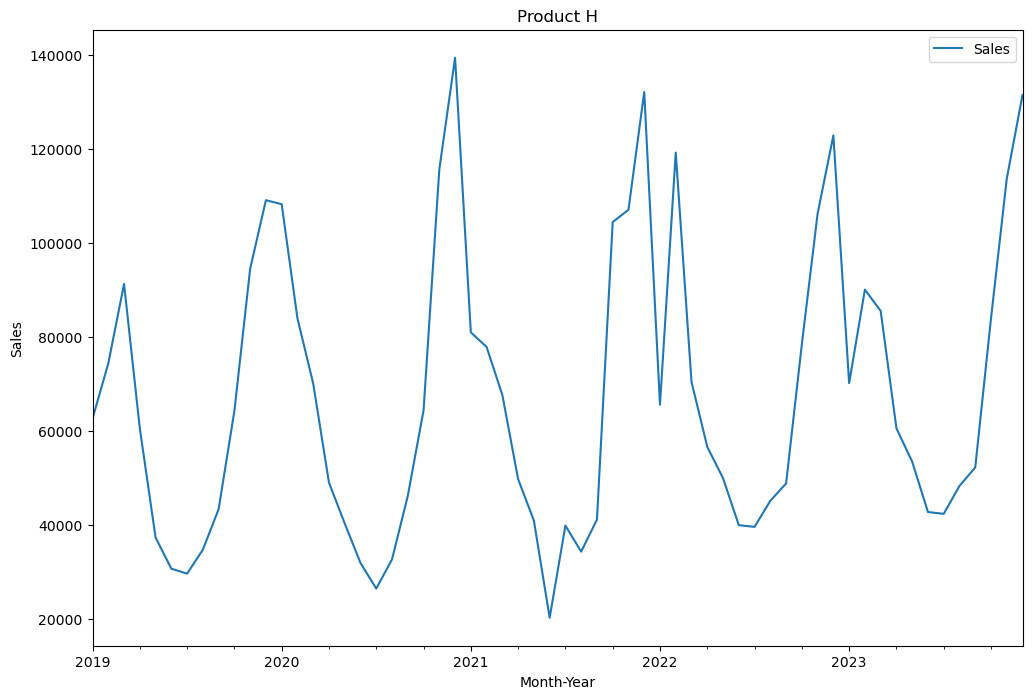

In [5]:
ax = sales_h.set_index('ds')['y'].plot(figsize=(12, 8))
ax.set_ylabel('Sales')
ax.set_xlabel('Month-Year')
plt.title('Product H')
plt.legend(['Sales'])
plt.show()


In [6]:
train= sales_h[:48]
test=sales_h[48:]

In [7]:
changepoint_prior_scale_range = [0.001, 0.01, 0.1,0.2, 0.3, 0.5]
seasonality_prior_scale_range = [0.01, 0.1, 1.0, 3.0, 5.0, 10.0]
seasonality_mode_range = ['additive', 'multiplicative']

param_grid = {  
    'changepoint_prior_scale': changepoint_prior_scale_range,
    'seasonality_prior_scale': seasonality_prior_scale_range,
    'seasonality_mode' : seasonality_mode_range
}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmses = []  # Store the RMSEs for each params here

# Use cross validation to evaluate all parameters
for params in all_params:
    m = Prophet(**params)
    m.add_regressor('Market Size')
    m.add_regressor('Marketing Expense')
    m.fit(train)
    df_cv = cross_validation(m, initial='730 days', period='365 days', horizon = '365 days', parallel="processes")
    df_p = performance_metrics(df_cv, rolling_window=1)
    rmses.append(df_p['rmse'].values[0])

# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['rmse'] = rmses
print(tuning_results)

12:38:42 - cmdstanpy - INFO - Chain [1] start processing
12:38:42 - cmdstanpy - INFO - Chain [1] done processing
12:38:45 - cmdstanpy - INFO - Chain [1] start processing
12:38:46 - cmdstanpy - INFO - Chain [1] done processing
12:38:49 - cmdstanpy - INFO - Chain [1] start processing
12:38:50 - cmdstanpy - INFO - Chain [1] done processing
12:38:54 - cmdstanpy - INFO - Chain [1] start processing
12:38:54 - cmdstanpy - INFO - Chain [1] done processing
12:38:59 - cmdstanpy - INFO - Chain [1] start processing
12:38:59 - cmdstanpy - INFO - Chain [1] done processing
12:39:03 - cmdstanpy - INFO - Chain [1] start processing
12:39:03 - cmdstanpy - INFO - Chain [1] done processing
12:39:07 - cmdstanpy - INFO - Chain [1] start processing
12:39:07 - cmdstanpy - INFO - Chain [1] done processing
12:39:11 - cmdstanpy - INFO - Chain [1] start processing
12:39:12 - cmdstanpy - INFO - Chain [1] done processing
12:39:15 - cmdstanpy - INFO - Chain [1] start processing
12:39:16 - cmdstanpy - INFO - Chain [1]

    changepoint_prior_scale  seasonality_prior_scale seasonality_mode  \
0                     0.001                     0.01         additive   
1                     0.001                     0.01   multiplicative   
2                     0.001                     0.10         additive   
3                     0.001                     0.10   multiplicative   
4                     0.001                     1.00         additive   
..                      ...                      ...              ...   
67                    0.500                     3.00   multiplicative   
68                    0.500                     5.00         additive   
69                    0.500                     5.00   multiplicative   
70                    0.500                    10.00         additive   
71                    0.500                    10.00   multiplicative   

            rmse  
0   11083.200476  
1   13363.783971  
2   12983.600528  
3   12295.962991  
4   14643.486109  
..       

In [8]:
tuning_results.sort_values('rmse',ascending=True)

,changepoint_prior_scale,seasonality_prior_scale,seasonality_mode,rmse
60,0.50,0.01,additive,10964.345671
36,0.20,0.01,additive,11000.041983
12,0.01,0.01,additive,11004.913714
24,0.10,0.01,additive,11005.450254
48,0.30,0.01,additive,11026.894900
...,...,...,...,...
71,0.50,10.00,multiplicative,25871.217447
65,0.50,1.00,multiplicative,27552.742939
69,0.50,5.00,multiplicative,27623.619251
51,0.30,0.10,multiplicative,30305.106369


In [9]:
best_params = all_params[np.argmin(rmses)]
print(best_params)

{'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.1, 'seasonality_mode': 'additive'}


In [24]:
# Create a Prophet model
#model = Prophet(changepoint_prior_scale=0.0100, seasonality_prior_scale=4.006, interval_width=0.95)
model = Prophet(changepoint_prior_scale=0.01, seasonality_prior_scale=0.1, seasonality_mode= 'additive', interval_width=0.95)
model.add_regressor('Market Size')
model.add_regressor('Marketing Expense')

In [25]:
model.fit(train)

13:02:13 - cmdstanpy - INFO - Chain [1] start processing
13:02:13 - cmdstanpy - INFO - Chain [1] done processing


In [26]:
# Create a DataFrame for future dates (including 2023)
future_dates = model.make_future_dataframe(periods=len(test), freq='MS')  # 12 months in 2023

In [27]:
future_dates['Market Size'] = sales_h['Market Size']
future_dates['Marketing Expense'] = sales_h['Marketing Expense']

In [28]:
future_dates

,ds,Market Size,Marketing Expense
0,2019-01-01,142038,447509
1,2019-02-01,168635,531319
2,2019-03-01,206976,652116
3,2019-04-01,137309,432617
4,2019-05-01,84683,266809
5,2019-06-01,69648,219428
6,2019-07-01,67255,211904
7,2019-08-01,78824,248348
8,2019-09-01,98356,309885
9,2019-10-01,214290,675154


In [29]:
# Make predictions for the future
forecast = model.predict(future_dates)

In [30]:
forecasted_df=forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(12)

In [31]:
forecasted_df

,ds,yhat,yhat_lower,yhat_upper
48,2023-01-01,54708.668907,39713.507214,69119.695568
49,2023-02-01,67162.513482,52609.971561,80220.891064
50,2023-03-01,61955.174828,49682.722509,74736.277847
51,2023-04-01,41753.260963,28121.014455,54560.462128
52,2023-05-01,33598.699418,20466.863750,47169.567642
53,2023-06-01,24794.294989,11071.652966,38360.419388
54,2023-07-01,25084.436206,11059.825784,38230.661542
55,2023-08-01,29332.671885,16239.067107,43311.235293
56,2023-09-01,33974.608318,21126.397888,48307.132210
57,2023-10-01,58103.965327,44834.706457,71558.410611


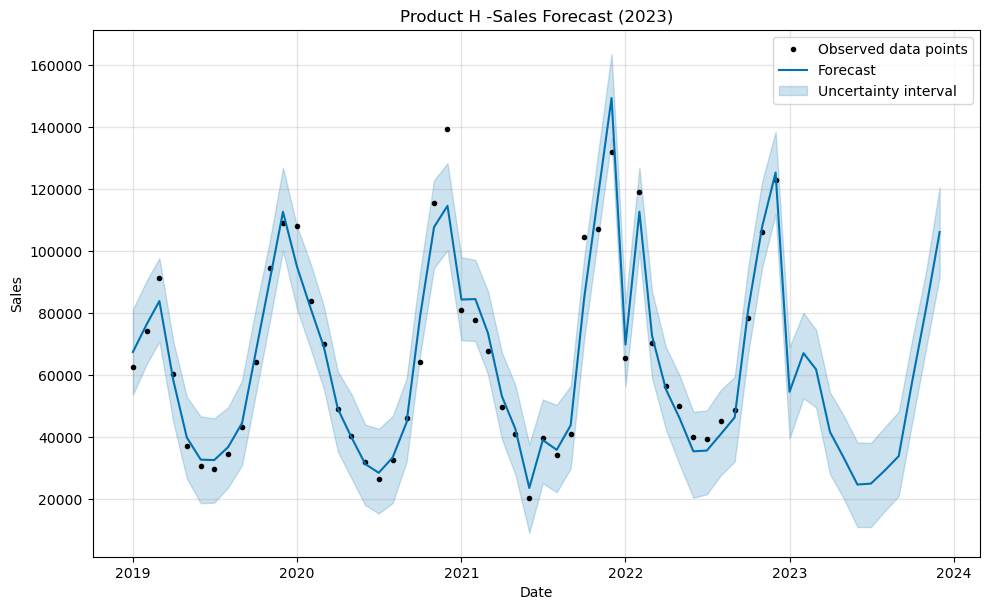

In [32]:
fig = model.plot(forecast, include_legend=True, uncertainty=True)
plt.title('Product H -Sales Forecast (2023)')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.show()

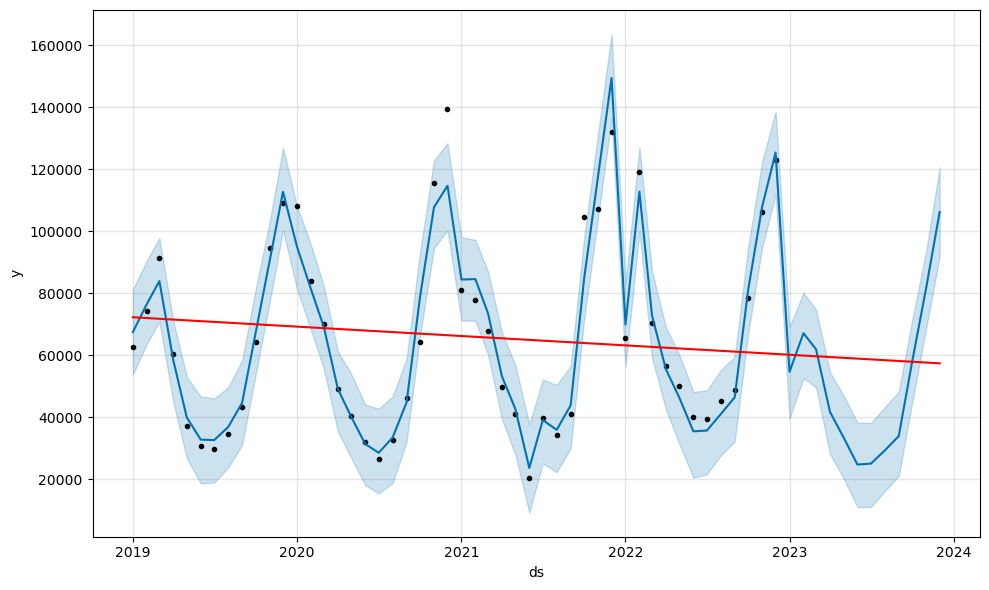

In [33]:
from prophet.plot import add_changepoints_to_plot
fig = model.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), model, forecast)

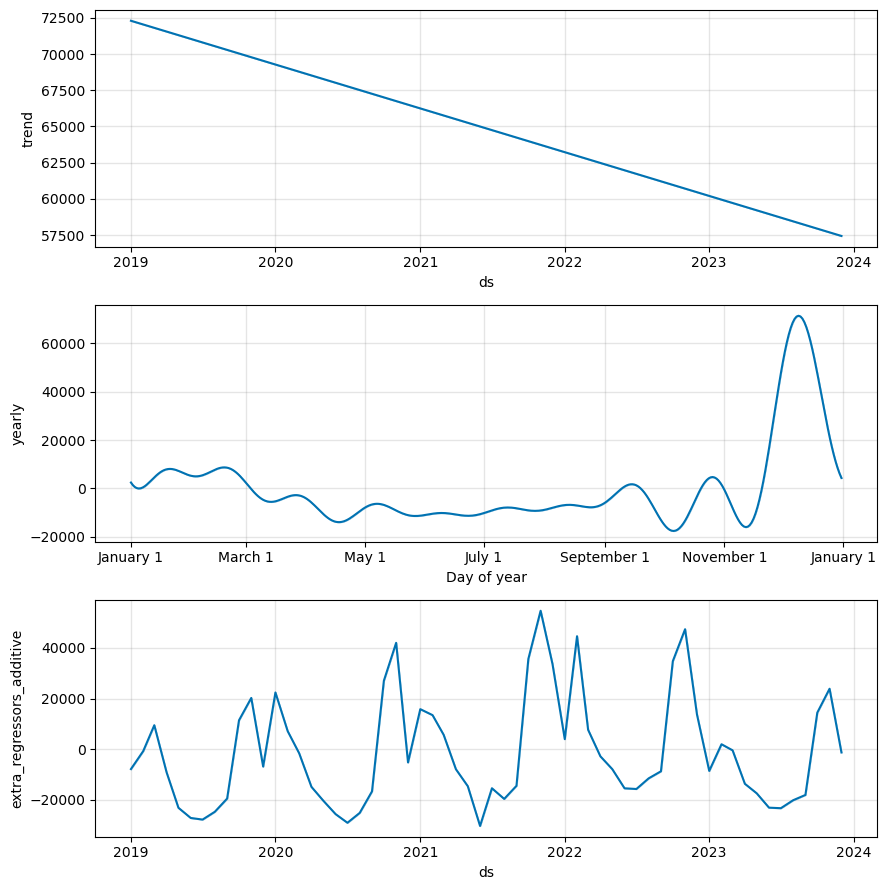

In [34]:
fig2 = model.plot_components(forecast)

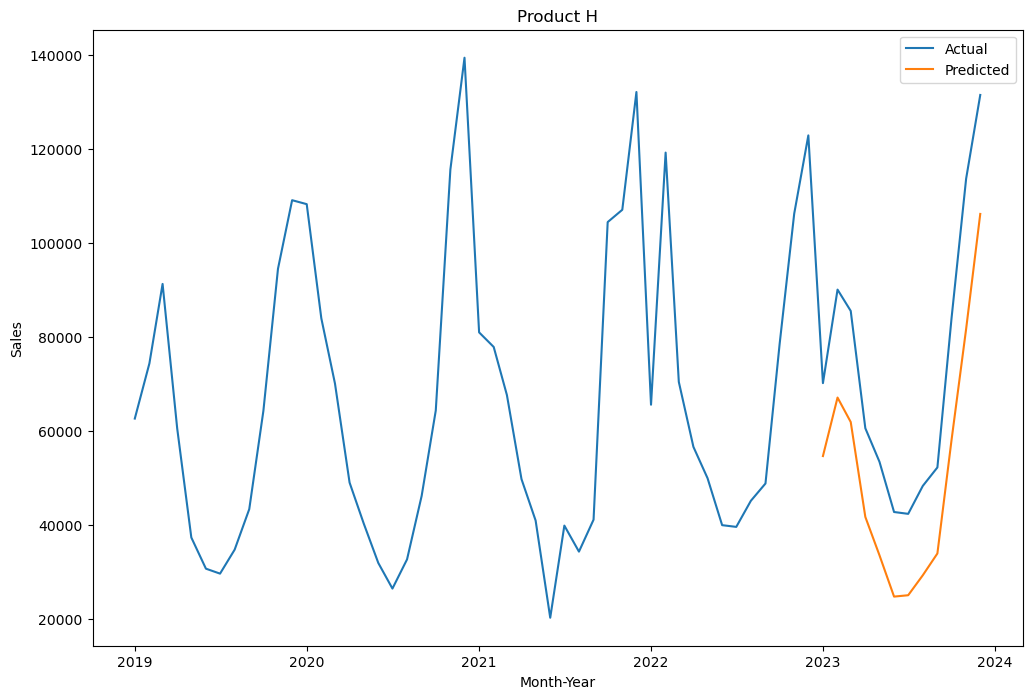

In [35]:
# Reset index of sales_b DataFrame
sales_h_reset_index = sales_h.reset_index()

# Plotting
plt.figure(figsize=(12, 8))
plt.plot(sales_h_reset_index['ds'], sales_h_reset_index['y'], label='Actual')
plt.plot(forecasted_df['ds'], forecasted_df['yhat'], label='Predicted')
plt.title('Product H')
plt.xlabel('Month-Year')
plt.ylabel('Sales')
plt.legend()
plt.show()

In [36]:
#model evaluation

In [37]:
pred=forecasted_df['yhat']
test_df=test['y']

In [38]:
mae_fb= mean_absolute_error(test_df,pred)
mse_fb=mean_squared_error(test_df, pred)
mape_fb= mean_absolute_percentage_error(test_df,pred)
rmse_fb= np.sqrt(mean_squared_error(test_df,pred))


print(f'MAE - FB PROPHET: {mae_fb:.3f}')
print(f'MAPE - FB PROPHET: {mape_fb:.3f}')
print(f'MSE - FB PROPHET: {mse_fb:.3f}')
print(f'RMSE - FB PROPHET: {rmse_fb:.3f}')

MAE - FB PROPHET: 21400.464
MAPE - FB PROPHET: 0.316
MSE - FB PROPHET: 478121100.083
RMSE - FB PROPHET: 21865.980


In [25]:
#Set initial window to 2 years (24 months), period to 1 year (12 months), and horizon to 1 year (12 months)
df_cv = cross_validation(model, initial='730 days', period='365 days', horizon='365 days', parallel="processes")

In [26]:
df_p = performance_metrics(df_cv)
df_p

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,31 days,1.381049e+07,3716.246667,3716.246667,0.056617,0.056617,0.055059,1.0
1,62 days,3.417684e+08,18486.980479,18486.980479,0.154957,0.154957,0.167971,0.0
2,90 days,2.838520e+04,168.479076,168.479076,0.002390,0.002390,0.002387,1.0
3,121 days,3.350207e+07,5788.097630,5788.097630,0.102142,0.102142,0.107640,1.0
4,151 days,1.046294e+08,10228.851232,10228.851232,0.204577,0.204577,0.227887,1.0
5,182 days,1.309618e+08,11443.854591,11443.854591,0.286096,0.286096,0.333854,1.0
6,212 days,1.011059e+08,10055.145197,10055.145197,0.253706,0.253706,0.290566,1.0
7,243 days,1.195502e+08,10933.899810,10933.899810,0.241959,0.241959,0.275260,1.0
8,274 days,6.209783e+07,7880.217942,7880.217942,0.161255,0.161255,0.175397,1.0
9,304 days,1.269244e+06,1126.607478,1126.607478,0.014348,0.014348,0.014451,1.0


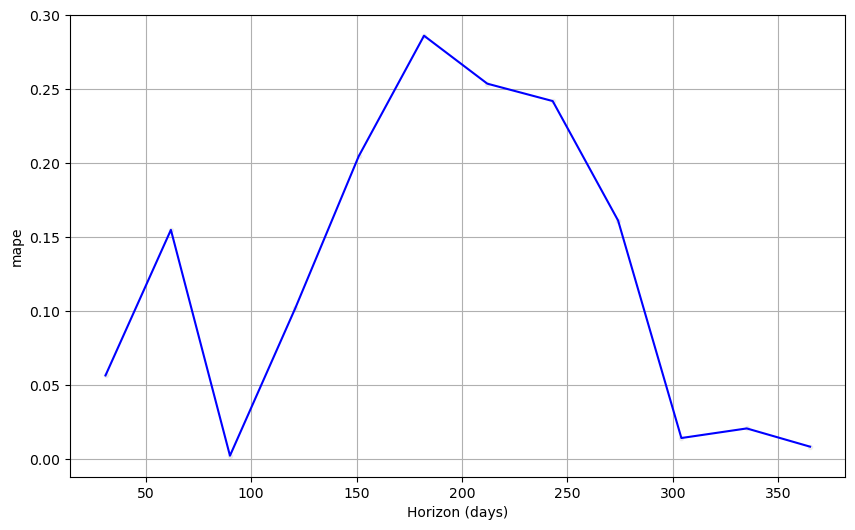

In [27]:
fig = plot_cross_validation_metric(df_cv, metric='mape')